In [1]:
"""
import packages
"""
import os, glob
import json
import pandas as pd
import numpy as np
import math, random
import datetime as dt
import pickle
from matplotlib import pyplot as plt
import argparse
import path, sys, re, time
from collections import Counter
from scipy.spatial import distance_matrix
from scipy.signal import find_peaks

In [2]:
"""
import custom packages
"""
from module_.info.testbed import activityfiles_new
from module_.info.config import config, feature_name
from module_.readText import create_episodes, time_correction
from module_.featureExtraction import feature_extraction
from module_.changePointDetection import change_point_detection

# Testbed (Seminar, multi-resident, episodes)

In [3]:
"""
load raw files
"""

dir_="dataset/testbed/npy/seminar/MS"
task_dict={i:[np.load("{}/{}".format(dir_, name)) for name in v] for i, v in enumerate(activityfiles_new.values())}
initial_dict={i:k[0] for i, k in enumerate(activityfiles_new.keys())}
label_dict={k[0]:k for k in activityfiles_new.keys()}

episodes, trs, tags = create_episodes(task_dict, initial_dict)
episodes=[time_correction(eps, trs[i]) for i, eps in enumerate(episodes)]

24


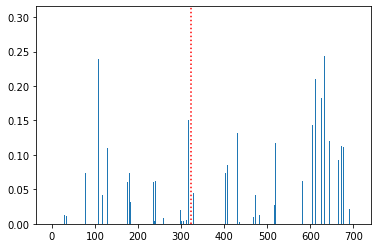

In [4]:
data_name = 'testbed'
metric = 'SEP'

folder = "./features/{}".format(data_name)
if not os.path.exists(folder):
    os.mkdir(folder)

# fig = plt.figure(constrained_layout=True, figsize=(15, 15))

sensor_set=set()

for _, v in task_dict.items():
    for v_ in v:
        sensor_set = sensor_set | set(np.array(v_)[:,0])
sensor_list=sorted(sensor_set)
print(len(sensor_list))

for ei, eps in enumerate(episodes):
    activityfolder="{}/{}".format(folder, tags[ei])
    if not os.path.exists(activityfolder):
        os.mkdir(activityfolder)
    eps=np.array(eps)

    # afolder="{}/{}".format(activityfolder, ei)
    # if not os.path.exists(afolder):
    #     os.mkdir(afolder)
    
    features = np.array(feature_extraction(eps, data_name, sensor_list))

    assert len(eps)==len(features)
    
    x_ = range(len(eps))

    scores = np.array(change_point_detection(features, data_name, metric))
    scores[scores<0]=0

    assert len(eps)==len(scores)

    plt.bar(range(len(scores)), scores); plt.axvline(x=trs[ei], linestyle=':', color='r')
    break

    names = list(feature_name.values())
    numbasicfeatures = len(names)-2

    for fi in range(numbasicfeatures):
        ax_ = fig.add_subplot(numbasicfeatures+1, 1, fi+1)
        ax_.plot(x_, features[:,fi], '.-')
        ax_.axvline(trs[ei], linestyle=':', color='r')
        ax_.set_ylabel(names[fi])
        ax_.set_ylim(0,2)
    ax_ = fig.add_subplot(numbasicfeatures+1, 1, numbasicfeatures+1)
    ax_.bar(x_, scores, color='g')
    ax_.axvline(trs[ei], linestyle=':', color='r')
    ax_.set_ylabel(metric)
    ax_.set_ylim(0,1)
    fig.savefig("{}/feature_basic.png".format(activityfolder))
    fig.clf()

In [ ]:
"""make combinations
    1. pick one group type
    2. pick an activity stream from the group
    3. pick another group type w/o type 1.
    4. pick an activity stream from the group
"""
data_name='testbed'
preprocess='MS'
metric='SEP'

time_threshold=30
score_threshold=0.1

for i, eps in enumerate(episodes):

    if i%100==0:
        print("{}/{}".format(i, len(episodes)))

    pairname="{}-{}".format(label_dict[tags[i][0]], label_dict[tags[i][2]])

    pairfolder="./outputs/testbed/{}/{}".format(preprocess, pairname)
    if not os.path.exists(pairfolder):
        os.mkdir(pairfolder)
    epsfolder="{}/{}_{}_{}".format(pairfolder, i, tags[i], trs[i])
    if not os.path.exists(epsfolder):
        os.mkdir(epsfolder)
    
    
    # np.save("{}/events.npy".format(epsfolder), eps)

    sensor_list=sorted(set(eps[:,0]))
    features=feature_extraction(eps, data_name, sensor_list)
    # np.save("{}/features.npy".format(epsfolder), features)

    # featurefile=open("{}/feature_lasttime.txt".format(epsfolder), 'w')
    # featurefile.write("{}\n".format(sensor_list))
    # for featurevector in features:
    #     featurefile.write("{}\n".format(np.round(featurevector[12+len(sensor_list):], 2)))
    # featurefile.close()

    # continue
    
    scores=change_point_detection(features, epsfolder, data_name=data_name, metric=metric, save=False)
    scores=np.array(scores)
    scores[scores<0]=0

    # positives=[idx for idx in range(len(scores)) if scores[idx]>score_threshold]

    # peaks=[]
    # prevPeakTimestamp=-1
    # for p in positives:
    #     if prevPeakTimestamp==-1 or float(eps[p][2])-prevPeakTimestamp>=time_threshold*2:
    #         peaks.append(p)
    #         prevPeakTimestamp=float(eps[p][2])
    
###
    plt.title("{} {}".format(pairname, tags[i]))
    plt.ylabel('score')
    plt.xlabel('event')
    plt.ylim(0,2)
    # plt.plot(peaks, scores[peaks], 'rx')
    plt.bar(range(len(eps)), scores)
    plt.axhline(y=score_threshold, linestyle=':', color='c')
    plt.axvline(x=trs[i], linestyle=':', color='g', label='transition')
    plt.legend()

    break
    plt.savefig("{}/graph_lasttime.png".format(epsfolder))
    plt.clf()
###

# Evaluation

In [ ]:
"""
    hh101 Evaluation
    - load scores
"""

data_name='testbed'
preprocess='MS'
metric='RuLSIF'

total_counts=np.zeros(4)
denom = numer = 0

time_threshold=30
score_threshold=0.3

for activity_folder in glob.glob("./outputs/{}/{}/*".format(data_name, preprocess)):
    # one type of pairs
    activity_pair=activity_folder.split("/")[-1]
    print(activity_pair)
    pair_counts=np.zeros(4) # TP, FP, TN, FN

    for episode_folder in glob.glob("{}/*".format(activity_folder)):
        # print(episode_folder)
        denom+=1
        eps_order=int(episode_folder.split("/")[-1].split("_")[0])
        eps, point=episodes[eps_order], trs[eps_order]
        scores=np.load("{}/{}/scores.npy".format(episode_folder, metric))

        positives=[i for i in range(len(scores)) if scores[i]>score_threshold]

        peaks=[]
        prevPeakTimestamp=-1
        for p in positives:
            if prevPeakTimestamp==-1 or float(eps[p][2])-prevPeakTimestamp>=time_threshold*2:
                peaks.append(p)
                prevPeakTimestamp=float(eps[p][2])

        numer+=len(peaks)
        ttimestamp=float(eps[point][2])

        for i in range(len(scores)):
            if i in positives:
                if i==point:
                    pair_counts[0]+=1
                else:
                    # timestamp_b=float(eps[i-1][2])
                    timestamp_a=float(eps[i][2])
                    # if abs(ttimestamp-timestamp_b)<threshold or abs(ttimestamp-timestamp_a)<threshold:
                    if abs(ttimestamp-timestamp_a)<time_threshold:
                        pair_counts[0]+=1
                    else:
                        pair_counts[1]+=1
            else:
                if i==point:
                    pair_counts[3]+=1
                else:
                    pair_counts[2]+=1
    TPR_=pair_counts[0]/(pair_counts[0]+pair_counts[3])
    FPR_=pair_counts[1]/(pair_counts[1]+pair_counts[2])
    print("Avg. TPR and FPR: ({}, {})".format(TPR_, FPR_))

    total_counts+=pair_counts

TPR=total_counts[0]/(total_counts[0]+total_counts[3])
FPR=total_counts[1]/(total_counts[1]+total_counts[2])
print("Total Avg. TPR and FPR: ({}, {})".format(TPR, FPR))

print(numer/denom)